In [123]:
import cv2
import numpy as np
import torch
from torchvision import transforms
import os
from emotic import Emotic
import matplotlib.pyplot as plt

In [124]:
context_mean = [0.4690646, 0.4407227, 0.40508908]
context_std = [0.2514227, 0.24312855, 0.24266963]
body_mean = [0.43832874, 0.3964344, 0.3706214]
body_std = [0.24784276, 0.23621225, 0.2323653]
context_norm = [context_mean, context_std]
body_norm = [body_mean, body_std]

In [125]:
cat = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence', 'Disapproval', 'Disconnection', \
            'Disquietment', 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear','Happiness', \
            'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning']
cat2ind = {}
ind2cat = {}
for idx, emotion in enumerate(cat):
    cat2ind[emotion] = idx
    ind2cat[idx] = emotion

vad = ['Valence', 'Arousal', 'Dominance']
ind2vad = {}
for idx, continuous in enumerate(vad):
    ind2vad[idx] = continuous

In [126]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [127]:
# Using Emotic Pretrained Model

model_context = torch.load("model_context1.pth", map_location=device)
model_body = torch.load("model_body1.pth", map_location=device)
emotic_model = torch.load("model_emotic1.pth", map_location=device)

In [128]:
thresholds = torch.FloatTensor(np.load(os.path.join('results', 'val_thresholds.npy'))).to(device) 

In [197]:
model_context.eval()
model_body.eval()
emotic_model.eval()
models = [model_context, model_body, emotic_model]

In [214]:
x1, y1, x2, y2 = list(map(int, open('boxes.txt').readlines()[0].split()))

In [215]:
bbox = [int(x1), int(y1), int(x2), int(y2)]

In [216]:
image_context =  cv2.cvtColor(cv2.imread('img3.jpg'), cv2.COLOR_BGR2RGB)
image_body = image_context[bbox[1]:bbox[3],bbox[0]:bbox[2]].copy()

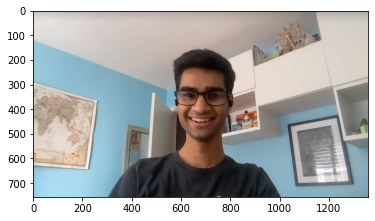

In [210]:
plt.imshow(image_context)

In [206]:
image_context = cv2.resize(image_context, (224,224))
image_body = cv2.resize(image_body, (128,128))

test_transform = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()])
context_norm = transforms.Normalize(context_norm[0], context_norm[1])  
body_norm = transforms.Normalize(body_norm[0], body_norm[1])

image_context = context_norm(test_transform(image_context)).unsqueeze(0)
image_body = body_norm(test_transform(image_body)).unsqueeze(0)

TypeError: 'Normalize' object is not subscriptable

In [217]:
image_context = cv2.resize(image_context, (224,224))
image_body = cv2.resize(image_body, (128,128))

image_context = test_transform(image_context).unsqueeze(0)
image_body = test_transform(image_body).unsqueeze(0)

In [220]:
image_context.shape

torch.Size([1, 3, 224, 224])

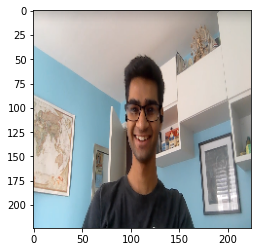

In [221]:
plt.imshow(np.transpose(image_context.squeeze(0), (1, 2, 0)))

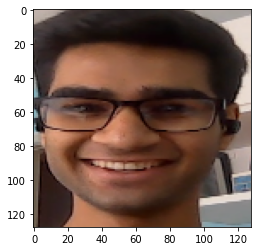

In [222]:
plt.imshow(np.transpose(image_body.squeeze(0), (1, 2, 0)))

In [223]:
model_context, model_body, emotic_model = models

In [224]:
with torch.no_grad():
    image_context = image_context.to(device)
    image_body = image_body.to(device)
    
    
    # Feed to models
    pred_context = model_context(image_context)
    pred_body = model_body(image_body)
    pred_cat, pred_cont = emotic_model(pred_context, pred_body)
    
    pred_cat = pred_cat.squeeze(0)
    pred_cont = pred_cont.squeeze(0).to("cpu").data.numpy()

    bool_cat_pred = torch.gt(pred_cat, thresholds)

In [225]:
cat_emotions = list()
for i in range(len(bool_cat_pred)):
    if bool_cat_pred[i] == True:
        cat_emotions.append((ind2cat[i], pred_cat[i]))

In [226]:
print ('\n Image predictions')
print ('Continuous Dimnesions Predictions') 
for i in range(len(pred_cont)):
    print ('Continuous %10s %.5f' %(ind2vad[i], 10*pred_cont[i]))
print ('Categorical Emotion Predictions')
for emotion in cat_emotions:
    print ('Categorical %16s - %6f' %(emotion[0], float(emotion[1])))


 Image predictions
Continuous Dimnesions Predictions
Continuous    Valence 5.86865
Continuous    Arousal 4.78364
Continuous  Dominance 6.27940
Categorical Emotion Predictions
Categorical       Confidence - 0.138398
Categorical     Disquietment - 0.109191
Categorical  Doubt/Confusion - 0.102308
Categorical        Happiness - 0.307362
Categorical         Pleasure - 0.113465


In [101]:
pred_cat

tensor([0.0356, 0.2515, 0.1871, 0.2980, 0.1558, 0.2137, 0.1525, 0.0511, 0.1325,
        0.1101, 0.0732, 0.5107, 0.0500, 0.1807, 0.0708, 0.0770, 0.1543, 0.1865,
        0.0066, 0.0587, 0.1239, 0.0211, 0.1619, 0.0634, 0.0430, 0.0401],
       device='cuda:0')